<a href="https://colab.research.google.com/github/jacklu98/python-random-quote/blob/master/%E2%80%9Cfeedforward_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import EMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw
image.shape: torch.Size([1, 28, 28])
Label: 45


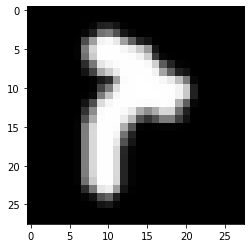

In [3]:
idx = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9",
       "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N",
       "O", "P", "Q","R","S","T", "U", "V", "W","X","Y","Z",
       "a", "b", "d","e", "f","g","h","n","q","r","t"]
dataset = EMNIST(root='data/', split="balanced", download=True, transform=ToTensor())
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.reshape(28,28), cmap='gray')
print('Label:', label) 

In [4]:
train_ds, val_ds = random_split(dataset, [94000, 18800])
len(train_ds), len(val_ds)

(94000, 18800)

In [5]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size1, hidden_size2, out_size):
        super().__init__()
        # hidden layer1
        self.linear1 = nn.Linear(in_size, hidden_size1)
        # hidden layer2
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        # output layer
        self.linear3 = nn.Linear(hidden_size2, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
input_size = 784
hidden_size1 = 64 # you can change this
hidden_size2 = 32
num_classes = 47
model = MnistModel(input_size, hidden_size1, hidden_size2, out_size=num_classes)
for t in model.parameters():
    print(t.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([47, 32])
torch.Size([47])


In [9]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 3.851839303970337
outputs.shape :  torch.Size([128, 47])
Sample outputs :
 tensor([[-0.0224, -0.0147,  0.0002, -0.0207,  0.0274, -0.1362, -0.0553,  0.1134,
          0.0343,  0.0247,  0.1514, -0.0088,  0.1302,  0.0597,  0.1683, -0.0790,
          0.0927, -0.0065,  0.1002,  0.0190,  0.1371,  0.0529, -0.0963,  0.1012,
          0.0147, -0.0089, -0.0737,  0.0338, -0.0362,  0.1769, -0.1211,  0.1006,
          0.1335,  0.0371,  0.0130,  0.1593, -0.0130, -0.0146,  0.1398,  0.1488,
         -0.0273, -0.0909,  0.0505,  0.0563, -0.0430, -0.0923,  0.0542],
        [-0.0108, -0.0021, -0.0223, -0.0555,  0.0318, -0.1335, -0.0557,  0.0740,
          0.0423,  0.0291,  0.1565, -0.0095,  0.1179,  0.0806,  0.1873, -0.1138,
          0.0976,  0.0042,  0.1052,  0.0187,  0.1674,  0.0542, -0.0967,  0.0625,
          0.0573,  0.0137, -0.0636,  0.0545, -0.0747,  0.1742, -0.1190,  0.0870,
          0.1338,  0.0007,  0.0306,  0.1655,  0.0091, -0.0430,  0.1479,  0.1172,
         -0.0180, -0.1190,  0.0653, 

In [10]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [11]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.023980453610420227, 'val_loss': 3.8547210693359375}]

In [12]:
history += fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.1531, val_acc: 0.6438
Epoch [1], val_loss: 0.9025, val_acc: 0.7159
Epoch [2], val_loss: 0.9508, val_acc: 0.7035
Epoch [3], val_loss: 0.8058, val_acc: 0.7368
Epoch [4], val_loss: 0.7142, val_acc: 0.7731


In [13]:
history += fit(5, 0.1, model, train_loader, val_loader) # small learning rate

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.5618, val_acc: 0.8186
Epoch [1], val_loss: 0.5651, val_acc: 0.8164
Epoch [2], val_loss: 0.5534, val_acc: 0.8199
Epoch [3], val_loss: 0.5548, val_acc: 0.8189
Epoch [4], val_loss: 0.5579, val_acc: 0.8197


In [14]:
history += fit(5, 0.01, model, train_loader, val_loader) # small learning rate

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.5373, val_acc: 0.8253
Epoch [1], val_loss: 0.5372, val_acc: 0.8255
Epoch [2], val_loss: 0.5358, val_acc: 0.8258
Epoch [3], val_loss: 0.5368, val_acc: 0.8274
Epoch [4], val_loss: 0.5359, val_acc: 0.8265


In [15]:
history += fit(25, 0.001, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.5354, val_acc: 0.8261
Epoch [1], val_loss: 0.5353, val_acc: 0.8264
Epoch [2], val_loss: 0.5352, val_acc: 0.8260
Epoch [3], val_loss: 0.5352, val_acc: 0.8263
Epoch [4], val_loss: 0.5352, val_acc: 0.8262
Epoch [5], val_loss: 0.5351, val_acc: 0.8263
Epoch [6], val_loss: 0.5351, val_acc: 0.8262
Epoch [7], val_loss: 0.5353, val_acc: 0.8260
Epoch [8], val_loss: 0.5352, val_acc: 0.8260
Epoch [9], val_loss: 0.5353, val_acc: 0.8260
Epoch [10], val_loss: 0.5352, val_acc: 0.8259
Epoch [11], val_loss: 0.5352, val_acc: 0.8261
Epoch [12], val_loss: 0.5352, val_acc: 0.8267
Epoch [13], val_loss: 0.5352, val_acc: 0.8262
Epoch [14], val_loss: 0.5352, val_acc: 0.8260
Epoch [15], val_loss: 0.5352, val_acc: 0.8263
Epoch [16], val_loss: 0.5353, val_acc: 0.8261
Epoch [17], val_loss: 0.5352, val_acc: 0.8264
Epoch [18], val_loss: 0.5352, val_acc: 0.8262
Epoch [19], val_loss: 0.5352, val_acc: 0.8264
Epoch [20], val_loss: 0.5352, val_acc: 0.8265
Epoch [21], val_loss: 0.5352, val_acc: 0.826

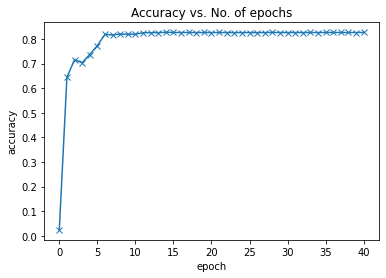

In [16]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [17]:
test_dataset = EMNIST(root='data/', split="balanced", train=False, transform=ToTensor())

In [18]:
img, label = test_dataset[0]
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()
predict_image(img, model)

41

In [19]:
for i in range(20):
    img, label = test_dataset[i]
    pred = predict_image(img, model)
    if pred == label:
        print("Label: ", idx[label], "Predict: ", idx[pred], "Yes")
    else:
        print("Label: ", idx[label], "Predict: ", idx[pred], "No")


Label:  g Predict:  g Yes
Label:  e Predict:  e Yes
Label:  9 Predict:  9 Yes
Label:  Q Predict:  Q Yes
Label:  q Predict:  q Yes
Label:  X Predict:  X Yes
Label:  E Predict:  E Yes
Label:  B Predict:  B Yes
Label:  3 Predict:  3 Yes
Label:  C Predict:  L No
Label:  G Predict:  G Yes
Label:  7 Predict:  7 Yes
Label:  2 Predict:  Z No
Label:  G Predict:  G Yes
Label:  G Predict:  G Yes
Label:  R Predict:  R Yes
Label:  6 Predict:  6 Yes
Label:  q Predict:  q Yes
Label:  S Predict:  S Yes
Label:  r Predict:  r Yes


In [20]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8235702514648438, 'val_loss': 0.5606080889701843}

In [ ]:
# save and reload trained model
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [ ]:
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0060,  0.0174,  0.0343,  ...,  0.0352, -0.0081, -0.0068],
                      [-0.0152,  0.0158, -0.0242,  ..., -0.0137,  0.0272, -0.0141],
                      [-0.0204,  0.0193,  0.0273,  ...,  0.0268,  0.0182,  0.0017],
                      ...,
                      [ 0.0109,  0.0109, -0.0330,  ..., -0.0246, -0.0297,  0.0300],
                      [ 0.0300,  0.0270, -0.0102,  ...,  0.0303,  0.0294, -0.0327],
                      [-0.0084, -0.0300,  0.0125,  ..., -0.0131, -0.0039,  0.0313]])),
             ('linear1.bias',
              tensor([-0.2534,  0.3337, -0.6185,  0.2065, -0.1075,  0.6803, -0.2381,  0.0504,
                      -0.0123, -0.6776, -0.0940, -0.2568,  0.2950,  0.2300,  0.2237,  0.2398,
                       0.1684,  0.7418,  0.1489,  0.0534,  0.3310,  0.6254,  0.1910, -0.0961,
                      -0.3299, -0.1848, -0.1591, -0.2585, -0.1940,  0.8580,  0.9351, -0.0060,
                      -0.179

In [ ]:
input_size = 784
hidden_size1 = 64
hidden_size2 = 32
num_classes = 10
model2 = model = MnistModel(input_size, hidden_size1, hidden_size2, out_size=num_classes)
model2.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0044,  0.0217,  0.0317,  ...,  0.0072,  0.0097, -0.0073],
                      [-0.0052, -0.0343,  0.0246,  ..., -0.0137,  0.0184, -0.0073],
                      [-0.0188, -0.0109,  0.0276,  ...,  0.0200,  0.0030, -0.0246],
                      ...,
                      [-0.0067, -0.0109, -0.0335,  ..., -0.0145, -0.0279, -0.0021],
                      [ 0.0277,  0.0109,  0.0265,  ..., -0.0095, -0.0229,  0.0178],
                      [-0.0115,  0.0310, -0.0208,  ..., -0.0125,  0.0154, -0.0272]])),
             ('linear1.bias',
              tensor([-0.0173, -0.0074, -0.0069, -0.0184, -0.0227, -0.0263,  0.0020, -0.0291,
                       0.0151, -0.0125, -0.0288,  0.0165,  0.0323,  0.0263,  0.0126,  0.0230,
                       0.0099,  0.0007, -0.0045,  0.0347, -0.0136,  0.0208, -0.0099, -0.0227,
                      -0.0186, -0.0130,  0.0064,  0.0105, -0.0159, -0.0104,  0.0232, -0.0146,
                       0.016

In [ ]:
result = evaluate(model2, test_loader)
result

{'val_loss': 2.310168743133545, 'val_acc': 0.06074218824505806}

In [ ]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0215, -0.0322, -0.0041,  ..., -0.0314, -0.0230,  0.0191],
                      [-0.0227, -0.0134,  0.0100,  ..., -0.0038,  0.0185, -0.0087],
                      [-0.0335,  0.0075,  0.0121,  ...,  0.0191,  0.0255, -0.0066],
                      ...,
                      [-0.0256,  0.0026,  0.0127,  ...,  0.0038, -0.0354, -0.0253],
                      [-0.0311, -0.0211,  0.0154,  ..., -0.0134, -0.0356,  0.0279],
                      [-0.0184,  0.0171,  0.0148,  ...,  0.0027, -0.0344, -0.0023]])),
             ('linear1.bias',
              tensor([ 0.0552, -0.0624,  0.1588,  0.0630, -0.0135, -0.1381,  0.0226, -0.1442,
                      -0.2062,  0.0027, -0.2543, -0.0334, -0.2168, -0.0311,  0.1815,  0.0329,
                       0.2390, -0.0144,  0.0449,  0.0307,  0.0366, -0.0079,  0.0092,  0.2058,
                       0.4038,  0.2215, -0.0295,  0.0552,  0.0331, -0.1183,  0.0534,  0.3658,
                       0.201

In [ ]:
result = evaluate(model2, test_loader)
result

{'val_loss': 0.07747671753168106, 'val_acc': 0.975878894329071}